In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.initializers import normal
from keras.utils import plot_model
from deap import base, creator, tools, algorithms
from deap.benchmarks.tools import diversity, convergence, hypervolume
from functools import partial
import numpy as np
import random

Using TensorFlow backend.


In [18]:
def build_model(n_layers, input_dim, neurons, activation='sigmoid', initializer=None):
    if isinstance(neurons, list):
        assert len(neurons) == n_layers
    else:
        neurons = [neurons] * n_layers
        
    if initializer is None:
        # Uses normal initializer
        initializer = normal(mean=0, stddev=0.1, seed=13)
        
    model = Sequential()
    
    # Adds first hidden layer with input_dim parameter
    model.add(Dense(units=neurons[0], 
                    input_dim=input_dim, 
                    activation=activation,
                    kernel_initializer=initializer, 
                    name='hidden_layer'))
    
    
    # Adds output layer
    model.add(Dense(units=2, activation=activation, kernel_initializer=initializer, name='net_output'))
    
    # Compiles the model
    model.compile(loss='mse', optimizer='Adam', metrics=['mse'])
    
    return model

In [3]:
data_dim = 7
x_train = np.random.random((1000, data_dim))

In [4]:
x_train.shape

(1000, 7)

In [ ]:
# randomly sellect one array
x_train[np.random.randint(x_train.shape[0], size=1), :]

In [19]:
model = build_model(n_layers=1, input_dim=7, neurons=5)

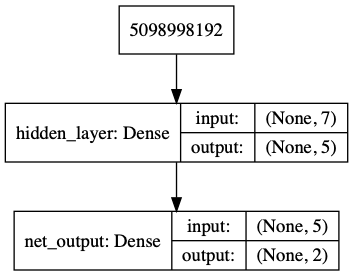

In [11]:
# Plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [14]:
model.predict(x_train)

array([[0.50357944, 0.4749498 ],
       [0.5039923 , 0.47484723],
       [0.5035746 , 0.47493932],
       ...,
       [0.50381374, 0.4747003 ],
       [0.503636  , 0.4741145 ],
       [0.5041812 , 0.47583416]], dtype=float32)

In [15]:
model.predict(x_train[np.random.randint(x_train.shape[0], size=1), :])

array([[0.5043149 , 0.47502902]], dtype=float32)

In [ ]:
model.predict(x_train[np.random.randint(x_train.shape[0], size=1), :])[0]

In [ ]:
print(model.summary())

In [ ]:
model.get_weights()

In [ ]:
model.get_layer(name='hidden_layer')

In [ ]:
# including the bias weights
for l in model.layers:
    print(l.get_config())
    print(l.get_weights())

In [ ]:
creator.create("FitnessMax", base.Fitness, weights=(1.0, 1.0))
creator.create("Individual", list, fitness=creator.FitnessMax, model=None)

In [ ]:
def initIndividual(cls, model):
    weights = [np.random.permutation(w.flat).reshape(w.shape) for w in model.get_weights()]
    return cls(weights)

In [ ]:
toolbox = base.Toolbox()
toolbox.register("individual", initIndividual, creator.Individual, model=model)

In [ ]:
ind1 = toolbox.individual()

In [ ]:
ind1.fitness.values = (1.0, 1.1)
print(ind1.fitness)

In [ ]:
mutant = toolbox.clone(ind1)
ind2, = tools.mutGaussian(mutant, mu=0.0, sigma=0.2, indpb=0.2)
del mutant.fitness.values

In [ ]:
def mutateIndividual(individual):
    mutant = toolbox.clone(ind1)
    mutated_ind = [tools.mutGaussian(weight, mu=0.0, sigma=0.2, indpb=0.9) for weight in mutant]
    del mutant.fitness.values
    return mutated_ind

In [ ]:
ind1

In [ ]:
mutateIndividual(ind1)

In [ ]:
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [ ]:
pop = toolbox.population(n=20)

In [ ]:
pop[0]

In [ ]:
pop[1]

In [ ]:
def eval_function(model, chromosome):
    x_data = np.random.random((1, 8))
    net_output = model.predict(x_data)[0]
    return (net_output[0]*np.random.random_sample(), net_output[1]*np.random.random_sample(),)

In [ ]:
def mutate_individual(individual):
    for i, weight in enumerate(individual):
        w, = tools.mutFlipBit(weight.flatten(), indpb=0.3)
        individual[i] = w.reshape(weight.shape)
    return individual

In [ ]:
def mate_individuals(ind1, ind2):
    for i, (w1, w2) in enumerate(zip(ind1, ind2)):
        cx1, cx2 = tools.cxTwoPoint(w1.flatten(), w2.flatten())
        ind1[i], ind2[i] = cx1.reshape(w1.shape), cx2.reshape(w2.shape)
    return ind1, ind2

In [ ]:
"""Multiobjective optmization"""
model = build_model(1, 8, 5)
# Creating the appropriate type of the problem
creator.create("FitnessMax", base.Fitness, weights=(1.0, 1.0))
creator.create("Individual", list,
               fitness=creator.FitnessMax, model=None)

def initIndividual(cls, model):
    weights = [np.random.permutation(w.flat).reshape(
        w.shape) for w in model.get_weights()]
    return cls(weights)

toolbox = base.Toolbox()
history = tools.History()
toolbox.register("individual", initIndividual,
                 creator.Individual, model=model)

 # register the crossover operator
toolbox.register('mate', mate_individuals)
# register the mutation operator
toolbox.register('mutate', mutate_individual)
# register the evaluation function
toolbox.register('evaluate', partial(eval_function, model))
# register NSGA-II multiobjective optimization algorithm
toolbox.register("select", tools.selNSGA2)
 # instantiate the population
toolbox.register('population', tools.initRepeat,
                 list, toolbox.individual)

# maintain stats of the evolution
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register('avg', np.mean)
stats.register('std', np.std)
stats.register('min', np.min)
stats.register('max', np.max)

logbook = tools.Logbook()
logbook.header = "gen", "evals", "std", "min", "avg", "max"

# create an initial population of N individuals
pop = toolbox.population(n=20)
history.update(pop)

def eq(ind1, ind2):
    return np.array_equal(ind1[0], ind2[0])
    

# object that contain the best individuals
hof = tools.ParetoFront(eq)

# Evaluate the individuals with an invalid fitness
invalid_ind = [ind for ind in pop if not ind.fitness.valid]

In [ ]:
fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)

In [ ]:
for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

In [ ]:
# This is just to assign the crowding distance to the individuals
# no actual selection is done
pop = toolbox.select(pop, len(pop))

record = stats.compile(pop)
logbook.record(gen=0, evals=len(invalid_ind), **record)
print(logbook.stream)
hof.update(pop)

In [ ]:
best_inds, best_inds_fitness = [], []

# Begin the generational process
for gen in range(1, 21):
    # Vary the population
    offspring = tools.selTournamentDCD(pop, len(pop))
    offspring = [toolbox.clone(ind) for ind in offspring]

    for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
        if random.random() <= 0.9:
            toolbox.mate(ind1, ind2)

        toolbox.mutate(ind1)
        toolbox.mutate(ind2)
        del ind1.fitness.values, ind2.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    best_ind = tools.selBest(pop, 1)[0]
    best_inds.append(best_ind) # add the best individual for each generation
    best_inds_fitness.append(best_ind.fitness.values)

    # Select the next generation population
    pop = toolbox.select(pop + offspring, len(offspring))
    record = stats.compile(pop)
    logbook.record(gen=gen, evals=len(invalid_ind), **record)
    hof.update(pop)
    
print("Final population hypervolume is %f" % hypervolume(pop, [11.0, 11.0]))

In [ ]:
offspring = tools.selTournamentDCD(pop, len(pop))
offspring = [toolbox.clone(ind) for ind in offspring]

In [ ]:
ind1 = offspring[0]
ind2 = offspring[1]

In [ ]:
def mate_individuals(ind1, ind2):
    for i, w1, w2 in enumerate(zip(ind1, ind2)):
        cx1, cx2 = tools.cxTwoPoint(w1.flatten(), w2.flatten())
        ind1[i], ind2[i] = cx1.reshape(w1.shape), cx2.reshape(w2.shape)
    return ind1, ind2

In [ ]:
ind1, ind2 = mate_individuals(ind1, ind2)

In [ ]:
type(ind2)

In [ ]:
ind1 = mutate_individual(ind1, 0.2)

In [ ]:
ind1.history_index

In [ ]:
toolbox.mate(ind1, ind2)

In [ ]:
ind1.__dict__

In [ ]:
d = np.array([[0.25773812, 0.99876807, 0.98062046, 0.16666008, 0.19844747,
        0.85773822, 0.13071776],]).reshape((7,))

In [ ]:
model.predict(d)

In [ ]:
d.shape

In [38]:
data = np.array([0.25773812, 0.99876807, 0.98062046, 0.16666008, 0.19844747, 0.85773822, 0.13071776])
data = data.reshape((1, 7))
print(data.shape)
print(data)

(1, 7)
[[0.25773812 0.99876807 0.98062046 0.16666008 0.19844747 0.85773822
  0.13071776]]


In [37]:
model.predict(data)

array([[0.5031197 , 0.47535378]], dtype=float32)